In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# (1) EDA (Exploratory Data Analysis)

Let's first inspect the dataset with `.head()` and `.tail()` to retrieve the first 5 and the last 5 rows of the dataset. We see that it consists of a table of only 2 columns : `Month` and `#Passengers`. The first column, `Month`, actually contains string values consisting of a concatenation of year and month in the format `yyyy-mm`. The second column contains the number of passengers, in integer form. We can check that there is no missing data with `.isna().sum()`. To confirm the types of the values in each column, we can access the attribute `.dtypes`. Finally, we can get a first review of the quantitative columns, in this case only `#Passengers`, with the method `.describe()`.

In [24]:
path = 'data/AirPassengers.csv'
df = pd.read_csv(path)
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [25]:
df.tail()

,Month,#Passengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


In [26]:
df.isna().sum()

Month          0
#Passengers    0
dtype: int64

In [27]:
df.dtypes

Month          object
#Passengers     int64
dtype: object

In [28]:
df.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


We can even make a quick plot of the histogram of `#Passengers` to have an image of its distribution. We observe that it doesn't look like a normal distribution, and that it is rather irregular.

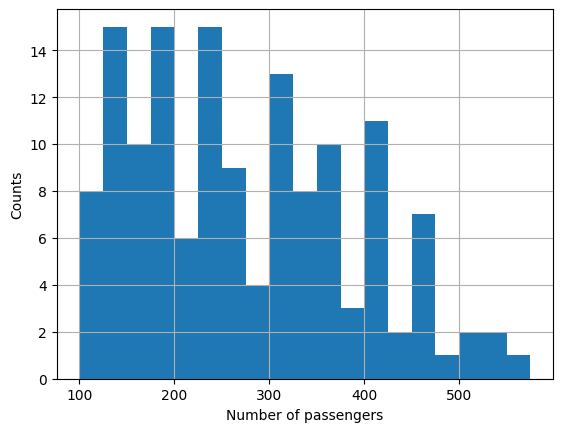

In [29]:
plt.hist(df['#Passengers'], bins=[100 + 25*i for i in range(20)])
plt.xlabel('Number of passengers')
plt.ylabel('Counts')
plt.grid()
plt.show()

We transform the `Month` column to datetime to facilitate the work for the following time-series analysis. Indeed, when working with dates and times, it's preferable that the Pandas dataframe is aware that a string column contains this type of values.

We make this new column `Date` the index of the table. This also ensures that there are no duplicates.

In [30]:
df['Date'] = pd.to_datetime(df['Month'], format='%Y-%m')
df = df.drop(columns=['Month'])
df = df.set_index('Date')
df.head()

,#Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


By plotting the number of passengers vs time, we observe this nice oscillating function with an increasing trend. Each year, the mean number of passengers is higher, and the seasonal effects are more important.

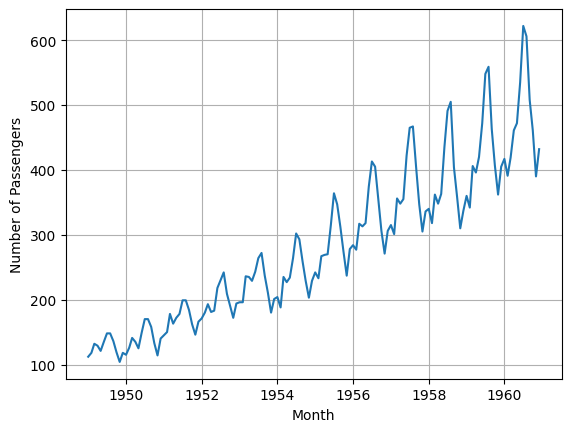

In [8]:
sns.lineplot(df, legend=False)
plt.ylabel('Number of Passengers')
plt.grid()
plt.show()

We can plot a zoomed in view of the last 2 years to determine that the seasonal increase of the number of passengers happens from june to september each year, with the peak at either july or august.

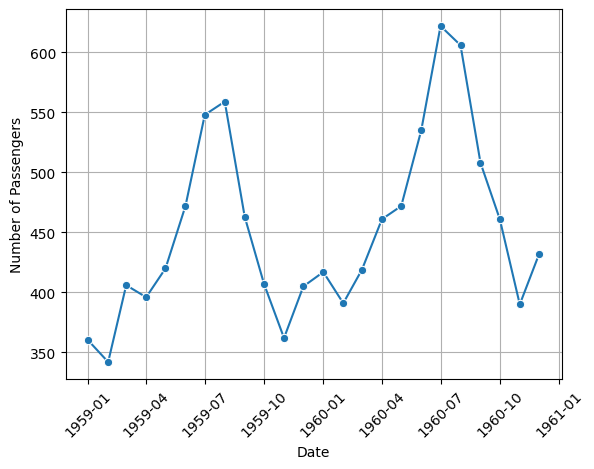

In [38]:
sns.lineplot(df[-24:], markers='o', legend=False)
plt.ylabel('Number of Passengers')
plt.xticks(rotation=45)
plt.grid()
plt.show()

As the seasonal effects are occurring in a frequency of one year, apparently, we can start to work with the rolling averages, that is, we group each set of 12 consecutive rows (as each row represents a month) and we compute the average of those values. So, we have a value for 1949 from january to december, a value for 1949 from february to december and 1950 january, etc. Alternatively, we can think that for each month from 1949 december to 1960 december, we have the average of the number of passengers of the last 12 months.

Indeed, if we plot this rolling averages, we see that the corresponding line (red) starts at 1949 december.

In [41]:
rolling_mean = df.rolling(12).mean()
rolling_std = df.rolling(12).std()
top = rolling_mean + rolling_std
bottom = rolling_mean - rolling_std

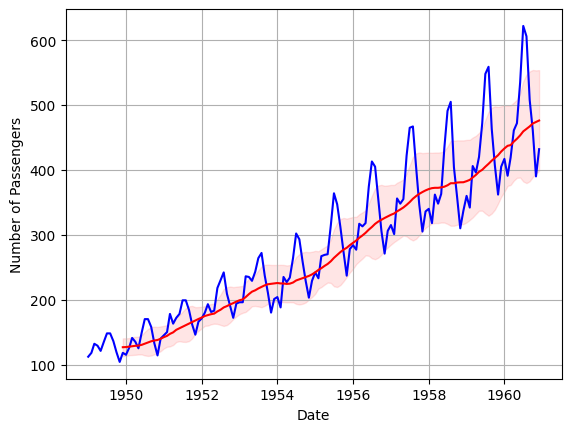

In [42]:
sns.lineplot(df, palette=['b'], legend=False)
sns.lineplot(rolling_mean, palette=['r'], legend=False)
plt.fill_between(bottom.index, bottom['#Passengers'], top['#Passengers'], color='r', alpha=.1)
plt.ylabel('Number of Passengers')
plt.grid()
plt.show()

We have also plotted the area around the rolling averages of 65% confidence. Indeed, this area corresponds to the intervals $[\mu - \sigma, \mu + \sigma]$. It's interesting to see that each year, the values of july and august fall out of this interval. They are, in a sense, outliers.

# (2) Statistical Analysis

We can use some functions of statsmodels to check some properties of the values. For instance, we can start with the A Dickey Fuller test to study the stationarity of the data. We expect negative results from this test, as we have observed that the data has a positive trend, and that the rolling averages grow every month.

In [43]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [44]:
adft = adfuller(df, autolag='AIC')
print(f'Test statistic = {adft[0]:.2f}')
print(f'p-value = {adft[1]:.2f}')

Test statistic = 0.82
p-value = 0.99


With such a high probability of the null hypothesis being true, we cannot reject it. The data is, as we expected, non-stationary.

Pandas also has a method to check autocorrelation among values at different intervals, or lags. Below, we check that the highest correlation happens for lags of 12 months. This is also coherent our observation that each year we have a very similar seasonal effect, with similar values each month, only with a slight increase of the average each year, that is, a positive trend.

In [13]:
autocorrelation_lag1 = df['#Passengers'].autocorr(lag=1)
print("One Month Lag: ", autocorrelation_lag1)

autocorrelation_lag3 = df['#Passengers'].autocorr(lag=3)
print("Three Month Lag: ", autocorrelation_lag3)

autocorrelation_lag6 = df['#Passengers'].autocorr(lag=6)
print("Six Month Lag: ", autocorrelation_lag6)

autocorrelation_lag9 = df['#Passengers'].autocorr(lag=9)
print("Nine Month Lag: ", autocorrelation_lag9)

autocorrelation_lag12 = df['#Passengers'].autocorr(lag=12)
print("One Year Lag: ", autocorrelation_lag12)

One Month Lag:  0.9601946480498522
Three Month Lag:  0.837394765081794
Six Month Lag:  0.7839187959206183
Nine Month Lag:  0.8278519011167602
One Year Lag:  0.9905273692085446


Another function of statsmodels is seasonal_decompose, that identifies the trend and the seasonal effect in the data.

The last plot shows the residuals, that is, the errors of this seasonal model. We see how the errors are low in the first years, but they can increase up to 50 passengers in the last rows of the dataset. This means that the seasonal effects are not so regular every year, and a simple model like this one might not be fit to extrapolate to new years.

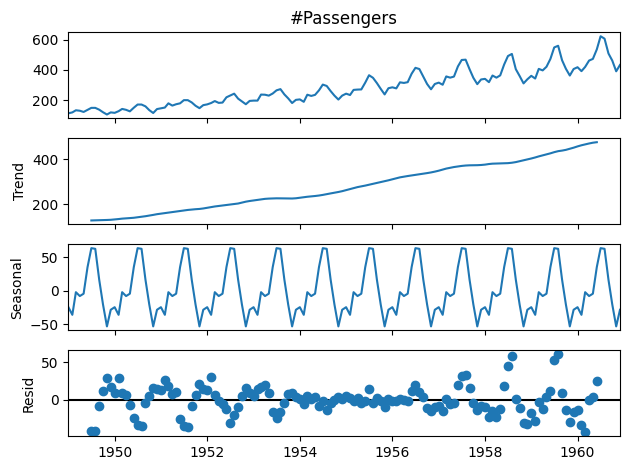

In [60]:
decompose = seasonal_decompose(df['#Passengers'], model='additive', period=12)
decompose.plot()
plt.show()